In [37]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [42]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [f"{i}_20_80" for i in range(100)] + [f"{i}_80_20" for i in range(100)],
            [0.004],
            [41],
        )
    ],
    columns=["region", "hsq", "ncausal"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"region-{row.region}-hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [43]:
dict_df_res = {}

for group in ["causal", "clump"]:
    df_res = []
    for param_i, param in tqdm(df_params.iterrows(), total=len(df_params)):
        for sim_i in range(100):
            path = f"out/summary/{param.prefix}/sim_{sim_i}.{group}.tsv"
            if os.path.exists(path):
                df_tmp = pd.read_csv(path, sep="\t")
                df_tmp["region"] = param.region
                df_tmp["ncausal"] = param.ncausal
                df_tmp["hsq"] = param.hsq
                df_tmp["sim_i"] = sim_i
                df_res.append(df_tmp)

    df_res = pd.concat(df_res).reset_index(drop=True)
    # filter for SNPs with super small MAF in either one of the populations
    df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
    print(group, np.mean(df_res.het_pval < 0.05))
    dict_df_res[group] = df_res

100%|██████████| 200/200 [00:09<00:00, 20.97it/s]


causal 0.5293989547038328


100%|██████████| 200/200 [00:09<00:00, 20.33it/s]


clump 0.4683423480750875


(-0.5, 0.5)

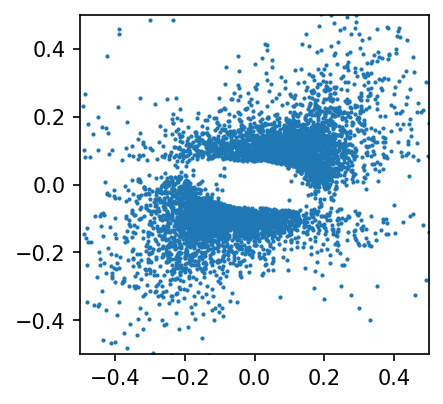

In [44]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
plt.scatter(df_res["coef1"], df_res["coef2"], s=1)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

In [45]:
admix_genet_cor.locus.deming_regression(
    df_res["coef1"], df_res["coef2"], df_res["se1"], df_res["se2"]
)

(0.8928870894268938, 0.00222885223314753)

In [47]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [48]:
dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = summarize_res(
        dict_df_res[group].groupby(["ncausal", "hsq", "sim_i"])
    ).drop(columns=["sim_i"])
    df_plot_mean = df_plot.groupby(["ncausal", "hsq"]).mean().reset_index()
    df_plot_sem = df_plot.groupby(["ncausal", "hsq"]).sem().reset_index()

    dict_df_plot[group] = (df_plot_mean, df_plot_sem)

In [49]:
for group in ["causal", "clump"]:
    print(group + ":")
    df_plot_mean, df_plot_sem = dict_df_plot[group]
    display(
        df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
        + "±"
        + df_plot_sem.set_index(["ncausal", "hsq"]).round(3).astype(str)
    )

causal:


,,het_inflation,het_fpr,pearsonr,deming_eur~afr,deming_afr~eur,ols_eur~afr,ols_afr~eur
ncausal,hsq,,,,,,,
41,0.004,10.581±1.416,0.529±0.021,0.386±0.035,1.425±0.05,0.705±0.027,0.346±0.028,0.433±0.046


clump:


,,het_inflation,het_fpr,pearsonr,deming_eur~afr,deming_afr~eur,ols_eur~afr,ols_afr~eur
ncausal,hsq,,,,,,,
41,0.004,8.177±1.507,0.502±0.047,0.441±0.017,0.878±0.053,1.156±0.075,0.258±0.009,0.767±0.073


In [50]:
y_var_list = [
    "het_fpr",
    "deming_afr~eur",
    "deming_eur~afr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Deming slope (AFR ~ EUR)",
    "Deming slope (EUR ~ AFR)",
    "Pearson's correlation",
    "OLS slope (AFR ~ EUR)",
    "OLS slope (EUR ~ AFR)",
]
dict_ylim = {
    "het_fpr": [0, 0.1],
    "pearsonr": [0.65, 1.35],
    "ols_afr~eur": [0.65, 1.35],
    "ols_eur~afr": [0.65, 1.35],
    "deming_afr~eur": [0.65, 1.35],
    "deming_eur~afr": [0.65, 1.35],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}

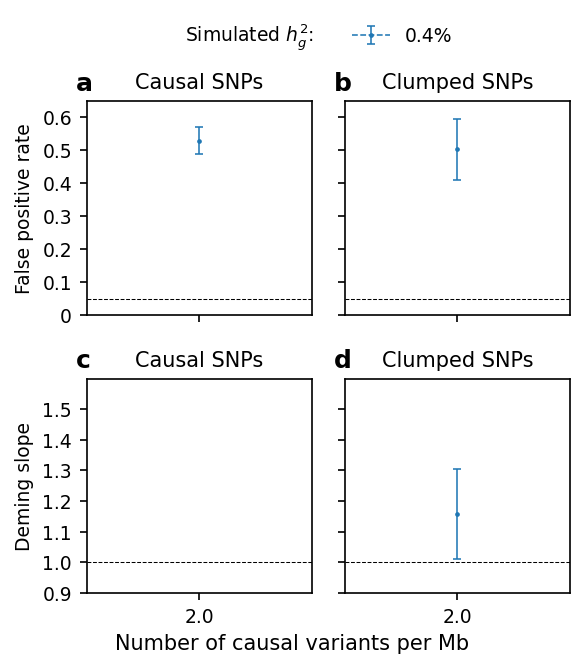

In [51]:
yvar_list = [
    "het_fpr",
    "deming_afr~eur",
]
dict_ylabel = {
    "het_fpr": "False positive rate",
    "deming_afr~eur": "Deming slope",
}
dict_ylim = {
    "het_fpr": [0, 0.65],
    "deming_afr~eur": [0.9, 1.6],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    "deming_afr~eur": [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
}
fig, axes = plt.subplots(
    figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
)
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for multiple causal
    df_mean = df_mean[df_mean.ncausal > 3]
    df_sem = df_sem[df_sem.ncausal > 3]

    for yvar_i, yvar in enumerate(yvar_list):
        ax = axes[yvar_i, group_i]
        for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
            df_mean_tmp = df_mean[df_mean.hsq == hsq]
            df_sem_tmp = df_sem[df_sem.hsq == hsq]
            ax.errorbar(
                np.arange(len(df_mean_tmp.ncausal)),
                df_mean_tmp[yvar],
                yerr=df_sem_tmp[yvar] * 1.96,
                fmt=".--",
                label=f"{hsq * 100}%",
                ms=3,
                linewidth=0.75,
                mew=0.75,
                capsize=2,
            )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
        ax.set_xticks(np.arange(len(df_mean_tmp.ncausal)))

        #         ax.set_xticklabels(df_mean_tmp.ncausal, fontsize=9)
        ax.set_xticklabels([str(i) for i in (df_mean_tmp.ncausal - 1) / 20], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
        if group_i == 0:
            ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_ylim(dict_ylim[yvar])

        if group == "causal":
            ax.set_title("Causal SNPs", fontsize=10)
        elif group == "clump":
            ax.set_title("Clumped SNPs", fontsize=10)

        # annotation
        ax.text(
            -0.05,
            1.05,
            string.ascii_lowercase[yvar_i * 2 + group_i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.0,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)


plt.tight_layout()
# fig.savefig("results/locus-simulation-multiple-causal.pdf", bbox_inches="tight")
plt.show()